In [1]:
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "2"
#device = 'cpu'  # TODO: CHANGE THIS!!!
import torch.nn.functional as F
import torch
from torch.utils.tensorboard import SummaryWriter
#from tensorboardX import SummaryWriter
from torch import optim
from sklearn import metrics
import numpy as np
import cv2
#os.environ['CUDA_LAUNCH_BLOCKING']='1'

#======= [ SETTING ] =======

MAX_PREDICTION_COUNT = 90
BATCH_SIZE=6
C = 0.1
R = 10
CONFIDENCE_THRESHOLD = 0.05

MODEL_FOLDER =r'./output/'

#LONAD_MODEL_NAME ="n90-c0.1-r10-0913-all-Aug-1023-with_aug_ep166.pth"  
LONAD_MODEL_NAME =""  
DO_AUG= False
#TRAIN_NAME = f"n90-c0.1-r10-10k-noAug-0104"
TRAIN_NAME = f"__Test__orign"
writer = SummaryWriter(TRAIN_NAME)

LOADED_EPOCH = None
LOADED_AP = None

TRAIN_DATASET_NAME  = "../../train_visiable_20_no_cross.json"
TEST_DATASET_NAME   = "../../test_visiable_10_no_cross.json"
#==============

#========= [ Log Setting ] ==========
MAX_LOG_GAP = 5
MAX_LOG_IT_COUNT = 5
EVAL_GAP = 5
save_auc = 0.2
log_folder = os.path.join(os.getcwd() , "output" , TRAIN_NAME )
if (not os.path.exists(log_folder)):
    os.makedirs(log_folder)   
#====================================

def reset_ncr_config(n, c, r ):
    global MAX_PREDICTION_COUNT
    global C
    global R
    global TRAIN_NAME
    global writer
    global log_folder

    MAX_PREDICTION_COUNT = n
    C = c 
    R = r
    #TRAIN_NAME = f"n{MAX_PREDICTION_COUNT}-c{C}-r{R}-0908"
    #TRAIN_NAME = f"n{MAX_PREDICTION_COUNT}-c{C}-r{R}-0913-all-Aug-1023"
    writer = SummaryWriter(TRAIN_NAME)

    log_folder = os.path.join(os.getcwd() , "output" , TRAIN_NAME )
    if (not os.path.exists(log_folder)):
        os.makedirs(log_folder)   

    pass


In [2]:
#======= [ Load Model ] =======
from horizon_model_direct import HorizonNet
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
net = HorizonNet('resnet50', True , MAX_PREDICTION_COUNT).to(device)   # For server (small memory)

if (LONAD_MODEL_NAME is not "" or None):          
    #state_dict = torch.load(f'./output/{LONAD_MODEL_NAME}', map_location='cpu')
    model_path = os.path.join(MODEL_FOLDER , LONAD_MODEL_NAME)
    state_dict = torch.load(model_path, map_location='cpu')
    print(state_dict.keys())
    net.load_state_dict(state_dict['state_dict'])
    LOADED_EPOCH    = state_dict['epoch']
    LOADED_AP       = state_dict['ap']
    save_auc        = LOADED_AP  
    print(LOADED_EPOCH,LOADED_AP)


optimizer = optim.Adam(
        filter(lambda p: p.requires_grad, net.parameters()),
        lr=1e-4, betas=(0.9, 0.999))
'''
'''

def reset_model():
    global net
    global optimizer
    net = HorizonNet('resnet50', True , MAX_PREDICTION_COUNT).to(device)
    optimizer = optim.Adam(
        filter(lambda p: p.requires_grad, net.parameters()),
        lr=1e-4, betas=(0.9, 0.999))

c:\Users\User\anaconda3\envs\Layout\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
c:\Users\User\anaconda3\envs\Layout\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [3]:
print(LOADED_EPOCH,LOADED_AP)

None None


In [4]:

#device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
from shapely.geometry import Polygon
def predict (data):    
    imgs = data['image'].to(device)        
    out = net(imgs)
    
    return out
    

# 輸出 [b , 5 , max_door_count]
#   Note: [b,0]為x座標，非原本的u_grad
def filter_peak_data(predict , min_threshold=-1):
    u  , v_top ,v_btm , d_top , d_btm  = predict

    b,n, _, w  = u.shape

    result = torch.zeros((b,5,n)).to(device)
    u = u .reshape(b,n,-1)
    v_top = v_top.reshape(b,n,-1)
    v_btm = v_btm.reshape(b,n,-1)
    d_top = d_top.reshape(b,n,-1)
    d_btm = d_btm.reshape(b,n,-1)

    peak_col_idx = torch.argmax(u,2)     

    #print("peak_idx" , peak_col_idx)
    for i in range(b):
        _t = torch.arange(MAX_PREDICTION_COUNT).to(device)
        idx = _t * w + peak_col_idx[i]             
        
        result[i,0,:]=peak_col_idx[i] / w  
        result[i,1,:]=v_top.reshape(b , -1)[i,idx]
        result[i,2,:]=v_btm.reshape(b , -1)[i,idx]
        result[i,3,:]=d_top.reshape(b , -1)[i,idx]
        result[i,4,:]=d_btm.reshape(b , -1)[i,idx]

        if(min_threshold>0):
            u_max_value_each_cha = torch.max(u[i] , 1)[0]            
            low_u_idx = torch.where(u_max_value_each_cha < min_threshold)[0]            
            result[i,0,low_u_idx] = -9999
        pass
        
        
        pass    
    return result

def encode(packed_data):
    _esp = 0.000001  # 避免有些門寬=0的爆炸 (真的會爆炸)
    packed_data[:,1] = torch.log( 0.5 - packed_data[:,1])  #v_top
    packed_data[:,2] = torch.log( packed_data[:,2] - 0.5)  #v_btm
    packed_data[:,3] = torch.log( packed_data[:,3] + _esp )  #du
    #packed_data[:,3] = torch.log( packed_data[:,3] )  #du
    packed_data[:,4] = torch.log( 0.5 - packed_data[:,4] + _esp)  #v_top2
    packed_data[:,5] = torch.log( packed_data[:,5] - 0.5 + _esp)  #v_btm2

    zeros = torch.zeros_like(packed_data)
    is_nan = torch.isnan(packed_data)
    packed_data = torch.where(is_nan , zeros , packed_data)    
    #packed_data = torch.nan_to_num(packed_data)
    return packed_data
    pass

#from scipy.spatial import distance_matrix
#def match_gt(gt_u , predict_u ):
def match_gt(gt_data , predict_data):
    
    # Filter out zero
    #zeros_mask = torch.zeros_like(gt_data[:,0,:])
    #ones_mask = torch.ones_like(gt_data[:,0,:])
    #print("gt_data[:,0,:]" , gt_data[:,0,:])
    nonZero_idx = torch.where(gt_data[:,0,:] != 0)[0]
    nonZero_idx = torch.unique(nonZero_idx ,return_counts=True)[1]
    #print("nonZero_idx" , nonZero_idx)
    
    
    gt_u = gt_data[:,0,:]    
    #print("filtered gt u " , gt_u )
    predict_u = predict_data[:,0,:]


    #print("mt u",gt_u.shape)
    #print("mt pu",predict_u.shape)
    #b , n , _ , __ = predict_u.shape
    b , n   = predict_u.shape
    #print(predict_u.shape)

    matched_gt_u = []
    matched_gt_vtop = []
    matched_gt_vbtm = []
    matched_gt_du = []
    matched_gt_dvtop = []
    matched_gt_dvbtm = []

    matched_prd_u = []
    matched_prd_vtop = []
    matched_prd_vbtm = []
    matched_prd_du = []
    matched_prd_dvtop = []
    matched_prd_dvbtm = []
    gt_idxs=[]
    #print("gt_before sort" , gt_data)
    #pos_idxs =[]
    #neg_idxs =[]
    #neg_pred_u = []
    u_interval = 1 / MAX_PREDICTION_COUNT    
    for i in range(b):
        #dist_mat = distance_matrix(gt_u[i] , predict_u[i] )
        # Sort by u distance
        pos_count =nonZero_idx[i]        

        sorted_gt_u , sorted_gt_idx  = torch.sort(gt_u[i,:pos_count] , dim=0)        
        #gt_data[i,:,:pos_count] = gt_data[i,:,sorted_gt_idx]       
        gt_data[i,:-1,:pos_count] = gt_data[i,:-1,sorted_gt_idx]        # -1: dont sort u_grad
        
        u_interval_idx = (sorted_gt_u / u_interval).type(torch.long)
        gt_idxs.append(u_interval_idx)
        #print("u_interval_idx" , u_interval_idx)

        target = torch.zeros((6,MAX_PREDICTION_COUNT)).to(device)                                
        target[0] = gt_data[i,-1]   # u_grad
        target[0,u_interval_idx] = 1   # 分類問題
        target[1:,u_interval_idx] = gt_data[i,1:-1,:pos_count]
        #target[1:,u_interval_idx] = gt_data[i,1:,:pos_count]


        matched_gt_u.append(target[0,:])
        matched_gt_vtop.append(target[1,:])
        matched_gt_vbtm.append(target[2,:])
        matched_gt_du.append(target[3,:])
        matched_gt_dvtop.append(target[4,:])
        matched_gt_dvbtm.append(target[5,:])


        matched_prd_u.append(predict_data[i,0,:])
        matched_prd_vtop.append(predict_data[i,1,:])
        matched_prd_vbtm.append(predict_data[i,2,:])
        matched_prd_du.append(predict_data[i,3,:])
        matched_prd_dvtop.append(predict_data[i,4,:])
        matched_prd_dvbtm.append(predict_data[i,5,:])
        #neg_pred_u.append(predict_data[i,0,neg_u_idx])
        
    '''
    return  matched_gt_u , matched_gt_vtop , matched_gt_vbtm ,\
            matched_gt_dtop ,matched_gt_dbtm , matched_prd_u , \
            matched_prd_vtop ,matched_prd_vbtm ,matched_prd_dtop , matched_prd_dbtm, \
            #pos_idxs,neg_idxs #neg_pred_u
    '''
    return  (matched_gt_u , matched_gt_vtop , matched_gt_vbtm , matched_gt_du ,matched_gt_dvtop ,matched_gt_dvbtm) ,\
            (matched_prd_u , matched_prd_vtop ,matched_prd_vbtm , matched_prd_du ,matched_prd_dvtop , matched_prd_dvbtm,),\
            gt_idxs
    
    pass
def get_grad_u(u ,_width = 1024):    
    u_len = u.shape[0]
    width = _width
    dist = torch.arange(0, width)
    #dist = dist.tile((u.shape[0],1) )            
    dist = dist.repeat((u.shape[0],1) )            
    dist = torch.abs( dist.float() - u.reshape((-1,1))*width )        
    c_dist = C ** dist              
    
    #c_dist[:u_len//2] = torch.max(c_dist[ 0::2 ] , c_dist[ 1::2 ])
    
    return c_dist

def get_grad_u_keep_batch(batch_u , pair =False , width = 1024):
    result =[]
    for u in batch_u:            
        w = u.shape[0]
        if (pair):
            u1 = get_grad_u(u[:w//2].cpu().detach() , width)
            u2 = get_grad_u(u[w//2:].cpu().detach() , width)
            result.append( torch.max(u1,u2))
        else:
            result.append(get_grad_u(u.cpu().detach() , width) )
    
    return result
def u_interval_to_real_u(u_interval , threshold = 0.25):
    
    mid_offset = 1/MAX_PREDICTION_COUNT *0.5
    line = torch.arange(MAX_PREDICTION_COUNT).to(device).float() /  float( MAX_PREDICTION_COUNT) + mid_offset    
    i = 0
    masks = []    
    for ui in u_interval:            
        zero_mask = torch.zeros_like(ui)
        one_mask = torch.ones_like(ui)
        #mask = (torch.sigmoid(ui) > threshold)
        mask = torch.where(torch.sigmoid(ui) > threshold , one_mask , zero_mask)
        masks.append(mask)
        u_interval[i] = mask * line
        i+=1
    
    return u_interval , masks
from scipy import ndimage
def find_N_peaks(signal, r=29, min_v=0.05, N=None):
    max_v = ndimage.maximum_filter(signal, size=r, mode='wrap')    
    pk_loc = np.where(max_v == signal)[0]
    pk_loc = pk_loc[signal[pk_loc] > min_v]
    if N is not None:
        order = np.argsort(-signal[pk_loc])
        pk_loc = pk_loc[order[:N]]
        pk_loc = pk_loc[np.argsort(pk_loc)]
    return pk_loc, signal[pk_loc]

def cal_loss(pred , gt , pk_idxs):
    #b = len(gt)
    l1_loss =  torch.nn.L1Loss()
    bce = torch.nn.BCEWithLogitsLoss()
        
    gt_u = torch.cat( gt[0])    
    pred_u = torch.cat( pred[0])    
    #print("gt vtop data " , gt[1])
    #print("pred vtop data " , pred[1])
    
    #u_loss = F.binary_cross_entropy_with_logits( pred_u , gt_u)            
    u_loss = bce( pred_u , gt_u)            
    #print("u_loss pred u ",  pred_u)
    #print("u_loss gt u ",  gt_u)
    
    #non_zero_idx = torch.where(gt_u > 0)[0]  
    non_zero_idx=[]
    i=0
    for pk in pk_idxs:
        non_zero_idx.append(pk + i * MAX_PREDICTION_COUNT)
        i+=1
    non_zero_idx = torch.cat(non_zero_idx)
    #print("cal loss idx" , non_zero_idx) 

    # other loss
    gt_vtop = torch.cat(gt[1])[non_zero_idx]    
    pred_vtop = torch.cat(pred[1])[non_zero_idx]
    
    v_top_loss = l1_loss(pred_vtop , gt_vtop )   

    pred_vbtm   = torch.cat(pred[2])[non_zero_idx]
    gt_vbtm     = torch.cat(gt[2])[non_zero_idx]
    v_btm_loss = l1_loss(pred_vbtm , gt_vbtm )
    #print("gt_vbtm" ,gt_vbtm)
    #print("pred_vbtm" ,pred_vbtm)

    pred_du = torch.cat(pred[3])[non_zero_idx]    
    gt_du = torch.cat(gt[3])[non_zero_idx]
    du_loss = l1_loss(pred_du , gt_du )

    pred_dtop = torch.cat(pred[4])[non_zero_idx]    
    gt_dtop = torch.cat(gt[4])[non_zero_idx]
    d_top_loss = l1_loss(pred_dtop , gt_dtop )

    pred_dbtm = torch.cat(pred[5])[non_zero_idx]    
    gt_dbtm = torch.cat(gt[5])[non_zero_idx]
    d_btm_loss = l1_loss(pred_dbtm , gt_dbtm )

    #losses = {"u_loss":u_loss *10, "v_top":v_top_loss , "v_btm":v_btm_loss,"du":du_loss ,"d_top":d_top_loss ,"d_btm":d_btm_loss }    
    #losses = {"u_loss":u_loss , "v_top":v_top_loss  , "v_btm":v_btm_loss  }    
    losses = {"u_loss":u_loss *20, "v_top":v_top_loss , "v_btm":v_btm_loss ,"du":du_loss ,"d_top":d_top_loss ,"d_btm":d_btm_loss }    
    #losses = {"u_loss":u_loss }    
    
    '''
    '''
    #print(losses)

    return losses
    '''
    [Debug]
    _img =  gt_grad_u[0].tile((10,1)).cpu().detach().numpy()
    _img2 =  pred_grad_u[0].tile((10,1)).cpu().detach().numpy()
    plt.imshow(_img , cmap='gray')
    plt.show()
    plt.imshow(_img2,cmap='gray')
    plt.show()
    '''
    pass

def to_bbox( u_pack , vt_pack , vb_pack ):

    u_flatten  = torch.cat(u_pack)
    vt_flatten  = torch.cat(vt_pack)
    vb_flatten  = torch.cat(vb_pack)

    non_zero_idx = torch.where(u_flatten>0)[0]
    u_flatten = u_flatten[non_zero_idx]
    vt_flatten = vt_flatten[non_zero_idx].reshape(-1 , 2)
    vb_flatten = vb_flatten[non_zero_idx].reshape(-1 , 2)

    vt_flatten = torch.min(vt_flatten , 1)[0]
    vb_flatten = torch.max(vb_flatten , 1)[0]

    bboxes=[]
    for i in range(vt_flatten.shape[0]):
        x1 = u_flatten[2*i]
        x2 = u_flatten[2*i+1]
        y1 = vt_flatten[i]
        y2 = vb_flatten[i]
        bboxes.append((x1,y1,x2,y2))
    bboxes = torch.as_tensor(bboxes).reshape(-1,4)
    return bboxes 
    pass

def decode(bdata , u_thresh = 0.25 , get_raw_u = False ):    
    #b ,c ,w = datas.shape
    #for bdata in datas:
    
    u = bdata[0] 
    vt = bdata[1]
    vb = bdata[2]
    du = bdata[3]
    dvt = bdata[4]
    dvb = bdata[5]        
    pk_idxs =[]
    #masks=[]
    #real_gt_u=[]
    for u_grad in u:
        #pk_idx = find_N_peaks(u_grad.cpu().detach().numpy() , r=r , min_v = u_thresh )[0]
        u_grad = torch.sigmoid (u_grad)    
        pk_idx = find_N_peaks(u_grad.cpu().detach().numpy() , r= R , min_v = u_thresh )        
        pk_idxs.append(pk_idx[0])
     
    
    b = len(u)    
    us =[]
    vts = []
    vbs = []
    scores= []
    for i in range(b):        
        du[i]  = torch.exp(du[i])
        pk_idx = pk_idxs[i]        
        with torch.no_grad():
            sig_u = torch.sigmoid(u[i][pk_idx])
        #scores.append(u[i][pk_idx])
        
        scores.append(sig_u)

        real_gt_u = pk_idx/MAX_PREDICTION_COUNT
        real_gt_u = torch.from_numpy(real_gt_u).to(device)
        if not get_raw_u:
            #_u = torch.hstack(( real_gt_u[i] , real_gt_u[i]+ du[i] * masks[i] )) % 1            
            #_u = torch.cat(( real_gt_u[i].float() , real_gt_u[i].float()+ du[i].float() * masks[i].float() ),0) % 1
            _u = torch.cat(( real_gt_u.float() , real_gt_u.float()  + du[i][pk_idx].float()   ),0) % 1
        else:
            #_u = torch.hstack(( real_gt_u[i] , real_gt_u[i]+ du[i] * masks[i] ))
            #_u = torch.cat(( real_gt_u[i].float() , real_gt_u[i].float()+ du[i].float() * masks[i].float() ),0)         
            _u = torch.cat(( real_gt_u .float() , real_gt_u.float()  + du[i][pk_idx].float()   ),0)

        vt1 = 0.5 - torch.exp(vt[i][pk_idx]) 
        vt2 = 0.5 - torch.exp(dvt[i][pk_idx]) 

        vb1 = torch.exp(vb[i][pk_idx]) +0.5
        vb2 = torch.exp(dvb[i][pk_idx]) +0.5

        #_vt = torch.hstack((vt1 , vt2 ))    
        #_vb = torch.hstack(( vb1, vb2))
        _vt = torch.cat((vt1 , vt2 ))    
        _vb = torch.cat(( vb1, vb2))
        
        us.append(_u)
        vts.append(_vt)
        vbs.append(_vb)

    #u_grads = get_grad_u_keep_batch(us , True)

    #return u,vt,vb , u_grad
    #return us ,vts,vbs , u_grads
    return us ,vts,vbs ,scores

def uv_to_xyz(u,v):
    uu = ( u*360-180) * 0.01745
    vv = ( v*180 -90) * 0.01745        
    
    # uv to 3D
    x =  np.cos(uu) * np.cos(vv)    
    y =  np.sin(uu) * np.cos(vv)
    z =  np.sin(vv)
    return x,y,z

def xyz_to_uv(x,y,z):
    theta   = np.arctan2(y,x)
    phi     = np.arcsin(z/(np.sqrt(x**2 +y**2+z**2)))

    theta   = (theta/ 0.01745 +180)/360
    phi     = (phi/0.01745 + 90)/180
    return theta,phi
    
def interplate_uv(u,v , count = 20):
    xs,ys,zs =[],[],[]

    for uu,vv in zip( u, v ):                    
        x,y,z = uv_to_xyz(uu,vv)
        xs.append(x)
        ys.append(y)
        zs.append(z)

    # 插值
    '''
    intp_x  = np.linspace(np.min(xs) , np.max(xs) , num=count )
    intp_y  = np.linspace(np.min(ys) , np.max(ys) , num=count )
    intp_z  = np.linspace(np.min(zs) , np.max(zs), num=count )
    '''
    intp_x  = np.linspace(xs[0] , xs[1] , num=count )
    intp_y  = np.linspace(ys[0] , ys[1] , num=count )
    intp_z  = np.linspace(zs[0] , zs[1], num=count )

    # 3D to uv
    thetas  =[]
    phis    =[]
    for x,y,z in zip (intp_x, intp_y, intp_z):
        theta , phi = xyz_to_uv(x,y,z)
        thetas.append(theta)
        phis.append(phi)
    return thetas , phis

def to_distorted_box(u,vt,vb , image = None  ,seg_cnt = None):

    canvas = np.zeros((512,1024,3)) if image is None else image    
    polys_per_img = []  #這張image的門，每個門可能有數個部位
    
    for _u , _vt , _bv  in zip(u, vt , vb):
        cross_idx = -1        
        previous_x = 0        
        seg_count =max(int((_u[1] -_u[0])*1024)//10 , 5) if seg_cnt is None else seg_cnt
        
        # Upper line
        all_points = [[None]*seg_count*2][0]
        thetas , phis= interplate_uv(_u,_vt , seg_count)
        i=0
        for t, p in zip(thetas , phis):            
            canvas = cv2.circle(canvas , (int(t*1024) , int(p *512)) , 3 , (255,0,0) ,-1 )            

            if(t< previous_x):
                cross_idx = i 
            
            previous_x = t
            all_points[i] = [t , p]

            i+=1

        # Bottom line
        thetas , phis= interplate_uv(_u,_bv , seg_count)        
        i=1
        for t, p in zip(thetas , phis):
            canvas = cv2.circle(canvas , (int(t*1024) , int(p *512)) , 3 , (255,0,0) ,-1 )            
            all_points[len(all_points)- i] = [t , p]
            i+=1
        
        # check cross      
        if(cross_idx >0):
            left_start_top = [0 ,all_points[cross_idx][1] ]
            left_start_btm = [0 ,all_points[seg_count + cross_idx][1] ]
            
            right_mid_top = [1 ,all_points[ cross_idx][1] ]
            right_mid_btm = [1 ,all_points[seg_count + cross_idx][1] ]

            part_right = all_points[:cross_idx] +[right_mid_top] +[right_mid_btm]+ all_points[seg_count + (seg_count - cross_idx):]
            #part_left = all_points[cross_idx: seg_count + (seg_count - cross_idx)]             
            part_left = [left_start_top] + \
                all_points[cross_idx: seg_count + (seg_count - cross_idx)] + [left_start_btm]            

            # ============= Clipping ===============
            
            part_left = np.array(part_left)
            part_right = np.array(part_right)
            right_min = part_right[0][0]
            right_clip_idx = np.where(part_right.flatten()[::2]<right_min)[0]

            if (right_clip_idx.size > 0):
                part_right[right_clip_idx,0]=1+0.00001

            left_max = part_left[len(part_left)//2][0] 
            left_clip_idx = np.where(part_left.flatten()[::2] > left_max)[0]


            '''
            print("all_points" , all_points)
            print("cross_idx" , cross_idx)
            print("seg_count" , seg_count)
            print("part_left" , part_left)
            print("part_right" , part_right)
            '''

            if (left_clip_idx.size > 0):
                part_left[left_clip_idx,0]=left_max+0.0001
            # ============= Clipping ===============

            polys = [part_left , part_right]

        else:
            polys = [all_points]

        polys_per_img.append(polys)
    '''
    # [DEBUG--- Show Result]
        for poly in polys:            
            poly = np.array(poly)
            poly = poly.reshape((-1 , 2)) * np.tile(np.array([1024 , 512]) , (poly.size//2 , 1) )
            poly = poly.astype('int32')               
            canvas =  cv2.polylines(canvas, [poly], True, (0,255,0), 2)

    plt.imshow(canvas)
    plt.show()
    '''
    return polys_per_img

def rearng(x):    
    half_idx = len(x)//2
    x1= x[:half_idx]
    x2= x[half_idx:]
    if(isinstance(x , np.ndarray)):
        arr = np.zeros_like(x)
    else:
        arr = torch.zeros_like(x)
    arr[::2] = x1    
    arr[1::2] = x2      

    return arr
def rearrange_decoded(u,vt,vb):    
    us ,vts ,vbs= [],[],[]
    for batch_u , batch_vt , batch_vb in zip(u,vt,vb):   
        if(isinstance(batch_u , np.ndarray)):
            ru = rearng(batch_u)        
            rvt = rearng(batch_vt)
            rvb = rearng(batch_vb)
        else:
            ru = rearng(batch_u.detach().cpu().numpy())        
            rvt = rearng(batch_vt.detach().cpu().numpy())
            rvb = rearng(batch_vb.detach().cpu().numpy())

        us.append(ru)
        vts.append(rvt)
        vbs.append(rvb)
    
    return us,vts,vbs

'''
boxu = [np.array([0.9556, 0.9921])]
boxvt = [np.array([0.3810, 0.4109])]
boxvb = [np.array([0.7335, 0.6852])]
'''
#Cross Image Set
boxu = [np.array([0.7444, 1.0161])]
boxvt = [np.array([0.2220, 0.2190])]
boxvb = [np.array([0.8964, 0.8982])]
'''

# Multi door
boxu = [np.array([0.8111, 0.3778, 1.2295, 0.6528])]
boxvt = [np.array([0.4642, 0.2425, 0.4658, 0.2188])]
boxvb = [np.array([0.5735, 0.8770, 0.5703, 0.8927])]
'''

gt_boxu = [ np.array([0.7111, 0.3578, 1.1095, 0.6528])]
gt_boxvt =[ np.array([0.4642, 0.2425, 0.4658, 0.2188])]
gt_boxvb =[ np.array([0.5735, 0.8770, 0.5703, 0.8927])]

'''
boxu = [np.array([0.1222, 0.6778, 0.7111, 0.1364, 0.6922, 0.7348])]
boxvt = [np.array([0.4698, 0.4242, 0.4627, 0.4723, 0.4376, 0.4620])]
boxvb = [np.array([0.5649, 0.6636, 0.5813, 0.5593, 0.6373, 0.5829])]
'''
boxu , boxvt , boxvb = rearrange_decoded(boxu , boxvt, boxvb)
gt_boxu , gt_boxvt , gt_boxvb = rearrange_decoded(gt_boxu , gt_boxvt, gt_boxvb)
#gt = [(0.8 , 0.23) , (1.1 , 0.23)  , (1.1 , 0.8) , (0.8 , 0.75) ]  # todo: gt不會cross borader
from shapely.validation import make_valid,explain_validity
def cal_poly_iou(poly_a , poly_b):
    
    if( len(poly_a) ==1 and len(poly_b) ==1): #比對的兩扇門都沒有跨畫面
        a_pg = Polygon(poly_a[0])
        b_pg = Polygon(poly_b[0])
        
        a_pg.buffer(0.0001)
        a_pg = a_pg.simplify(0.0001 ,preserve_topology=False)
        b_pg.buffer(0.0001)
        b_pg = b_pg.simplify(0.0001 , preserve_topology=False)

        poly_intersection   = a_pg.intersection(b_pg)
        poly_union          = a_pg.union(b_pg)
        if( poly_union.area== 0):
            iou=0
        else :
            iou                 = poly_intersection.area / poly_union.area
        #print("iou" , iou)
        return iou
        pass

    else:
        iou_matrix = np.zeros((len(poly_a) , len(poly_b)))      
        for i , a_points in enumerate( poly_a):
            a_pg = Polygon(a_points)
            a_pg.buffer(0.0001)
            a_pg = a_pg.simplify(0.001 ,preserve_topology=False)

            if(not a_pg.is_valid):                
                a_pg = make_valid(a_pg)
                print("a",a_pg.is_valid , explain_validity(a_pg))

            for j , b_points in enumerate( poly_b):
                b_pg = Polygon(b_points)
                b_pg.buffer(0.0001)
                b_pg = b_pg.simplify(0.001 , preserve_topology=False)

                if(not b_pg.is_valid):
                    b_pg = make_valid(b_pg)
                    print("b" , b_pg.is_valid , explain_validity(b_pg))
                
                poly_intersection   = a_pg.intersection(b_pg)
                poly_union          = a_pg.union(b_pg)
                if( poly_union.area== 0):
                    iou =0
                else:                
                    iou                 = poly_intersection.area / poly_union.area
                iou_matrix[i][j] =  np.float32( iou)
                #print("iou    " ,iou    )
        total_iou = np.sum(iou_matrix)/2
        #print("iou_matrix" , iou_matrix)
        #print("total iou" , total_iou)

        return total_iou
    pass

def get_iou_matrix_distored(gt , pred):    
    iou_matrix = np.zeros((len(gt) , len(pred)))        
    for i , _gt in  enumerate(gt):        
        for j , _pred in enumerate(pred):            
            iou  = cal_poly_iou(_gt, _pred)
            iou_matrix[i][j] = np.float32( iou)
    
    return iou_matrix


for batched_uvv in zip(boxu , boxvt , boxvb ):  #each image in batch
    #print("batched_uvv" , batched_uvv)
    u = batched_uvv[0].reshape(-1,2)
    vt = batched_uvv[1].reshape(-1,2)
    vb = batched_uvv[2].reshape(-1,2)    

    polys_point = to_distorted_box(u , vt , vb)

    u   = gt_boxu[0].reshape(-1,2)
    vt  = gt_boxvt[0].reshape(-1,2)
    vb  = gt_boxvb[0].reshape(-1,2)    

    gt_polys_point = to_distorted_box(u , vt , vb,seg_cnt=5)
    iou_matrix = get_iou_matrix_distored(gt_polys_point , polys_point)
    print("final iou_matrix",iou_matrix)

    




final iou_matrix [[0.21522403]
 [0.        ]]


In [5]:
# 定義dataloader
# [Load Data]
import os
import torch
from torchvision import transforms
import torchvision.transforms as T
from torchvision.transforms import Lambda
from torch.utils.data import Dataset, DataLoader
from PIL import Image, ImageOps
from torchvision.transforms import functional as F
from torch.utils.data import random_split
import json
from torch.nn.utils.rnn import pad_sequence


import matplotlib.pyplot as plt 
import cv2
import numpy as np
from scipy.spatial import distance

IMG_SIZE =  np.array([1024,512]) # [w,h]
#MAX_PREDICTION_COUNT = 256
#MAX_PREDICTION_COUNT = 20

#EPSILON = 0.00001

def collate_fn(batch):
    return tuple(zip(*batch))
    
debug_current_imgs_path =[""]* BATCH_SIZE 
debug_count=0

def gauss_noise_tensor(img):
    if np.random.rand() < 0.5 and DO_AUG:
        sigma = np.random.rand() *0.125
        out = img + sigma * torch.randn_like(img)
        return out
    return img

def blank(img):    
    return img

class CustomDataset(Dataset):
    global debug_current_imgs_path
    def __init__(self, annotations_file_path , img_size=[1024,512] , debug_doTrans= True):
        # Open json file        
        json_path =  annotations_file_path
        f= open(json_path)
        anno = json.loads(f.read())
        f.close()
        self.anno = anno
        self.img_size = img_size

        do_jitter = np.random.rand() > 0.5 if DO_AUG else False        
        self.debug_doTrans = debug_doTrans
        
        self.transform = transforms.Compose([    
            transforms.ToPILImage(),                    
            transforms.Resize((img_size[1], img_size[0])),            
            transforms.ColorJitter((0.4 , 1) , (0.7,1) , (0.6,1) , (-0.5, 0.5)) if self.debug_doTrans else blank,
            #transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),            
            gauss_noise_tensor if self.debug_doTrans else blank,
        ])


    def __len__(self):
        return len(self.anno)
    def get_bbox_count(self ):
        count =0
        for data in self.anno:            
            count += len(data['bboxes'])
        return count

    def __getitem__(self, idx):
        global epoch
        global train_itr

        #img_path = os.path.join("./", self.anno[idx]['image'])
        #img_path = os.path.join("/CGVLAB3/datasets/chingjia/data/data/", self.anno[idx]['image'])
        img_path = os.path.join("F:/THU/DoorSeg/OneDrive_2023-01-07/Door_Detection/data/data", self.anno[idx]['image'])
        #print(img_path)
        #image = read_image(img_path)           
        image = cv2.imread(img_path)        
        #plt.imshow(image)
        #plt.title("origin img")
        #plt.show()

        if(self.transform!=None):
            image= self.transform( image)

        if self.debug_doTrans:
            do_flip = np.random.rand() > 0 
            do_roll = np.random.rand() > 0       
        else:   
            do_flip=False
            do_roll=False

        _, h,w = image.shape

        target = self.anno[idx]
        data = {}

        u = torch.tensor(target['u'])
        u_0idx = torch.where(u==0)[0]  #避免u = 0在match上出error
        u[u_0idx] = 0.0000001
        
        v = torch.tensor(target['sticks_v'])        
        du = u.flatten()[1::2] - u.flatten()[0::2]

        #============ Transform ===========
        if do_flip:
            image = torch.flip(image, dims=[2])            
            u = torch.flip( 1 - u , [1])
            u_is_cross =  (u.flatten()[::2]<0).to(torch.float32)
            u_is_cross = u_is_cross.repeat_interleave(2)            
            u = (u.flatten() + 1* u_is_cross).reshape((-1,2))

            # 左右交換 => 0跟2互換 , 1跟3互換
            v_idx_all = torch.arange(v.numel())      
            v_idx = v_idx_all.clone()
            v_idx[0::4] = v_idx_all[2::4]
            v_idx[1::4] = v_idx_all[3::4]
            v_idx[2::4] = v_idx_all[0::4]
            v_idx[3::4] = v_idx_all[1::4]
            v= (v.flatten()[v_idx]).reshape(-1,4)

        if do_roll:
            shift_rand = torch.rand(1)
            shift = int((w * shift_rand ).tolist()[0])
            image = torch.roll(image , shift , 2 )            
            u = (u + shift_rand) % 1
        #============            ===========        
        u_grad = get_grad_u(u.flatten()[::2].reshape((-1,1)) , _width=MAX_PREDICTION_COUNT)        
        u_grad = torch.max(u_grad,0)[0]  
        
        #padding_count = (MAX_PREDICTION_COUNT - u.shape[0])
        padding_count = (MAX_PREDICTION_COUNT - u.numel()//2)
        padding_count = max(padding_count ,  0)        
        
        padding_count = abs( MAX_PREDICTION_COUNT*2 - u.numel())
        u_pad = torch.cat(( u.reshape(-1) , torch.zeros((padding_count )) )  )                
        du_pad = torch.cat(( du.reshape(-1) , torch.zeros((MAX_PREDICTION_COUNT - du.numel() )) )  )                

        
        v= v.flatten()        
        
        padding_count = abs( MAX_PREDICTION_COUNT *4 - v.numel() )
        v_top_pad = torch.cat(( v[::2] , torch.zeros((padding_count//2 )) )  )        
        v_btm_pad = torch.cat(( v[1::2] , torch.zeros((padding_count//2 )) )  )      
        

        #data['data_count'] = u.numel()
        data['image'] = image
        #data['u_grad'] = c_dist
        data['u_grad'] = u_grad
        data['u'] = u_pad [::2]
        #data['door_count'] = u.numel()//2
        #data['u'] = u_pad
        data['v_top'] = v_top_pad[::2]
        data['v_btm'] = v_btm_pad[::2]


        #data['du'] = torch.abs( u_pad[1::2] - u_pad[0::2])
        data['du'] = du_pad
        
        data['dv_top'] = v_top_pad[1::2]
        data['dv_btm'] = v_btm_pad[1::2]

        '''
        data['d_top'] = depth_top_pad
        data['d_btm'] = depth_btm_pad

        '''

        #=====================
        #|    output shape   |
        #=====================
        #   u: [n,2]
        #   u_grad: [n,1024]
        #   v_top: [n]
        #   v_btm: [n]

        return data

        #return data        

# [ Test  : Can Delete]
'''
#dataset = CustomDataset( "./output/train_visiable_horizon_2k.json"   ) 
#dataset = CustomDataset( "./output/train_visiable_horizon_200.json"   ) 
train_dataset = CustomDataset( f"./output/{TRAIN_DATASET_NAME}"  ,debug_doTrans= False ) 
#eval_dataset = CustomDataset( f"./output/{TEST_DATASET_NAME}"   ) 
#eval_dataset = CustomDataset( "./output/train_visiable_horizon_20.json"   ) 
#train_dataloader = DataLoader(train_dataset, BATCH_SIZE , shuffle=True, drop_last =True)
train_dataloader = DataLoader(train_dataset, BATCH_SIZE , shuffle=False, drop_last =True)
#eval_dataloader = DataLoader(eval_dataset, BATCH_SIZE , shuffle=True, drop_last =True)

data = next(iter(train_dataloader)) 
#pack_gt = (data['u'] , data['v_top'] , data['v_btm'] , data['d_top'] , data['v_top'] )
print(data['u'])
#print("vtop" ,data['v_top'])
#print("vbtm" ,data['v_btm'])
print("du" , data['du'])
#print(data)
print(data['u_grad'])
visualize_2d(     
    data['u'],
    data['v_top'],
    data['v_btm'],
    data['image'],
    data['u_grad'],
    #out_u
    #get_grad_u_keep_batch( real_gt_u)
)
'''




'\n#dataset = CustomDataset( "./output/train_visiable_horizon_2k.json"   ) \n#dataset = CustomDataset( "./output/train_visiable_horizon_200.json"   ) \ntrain_dataset = CustomDataset( f"./output/{TRAIN_DATASET_NAME}"  ,debug_doTrans= False ) \n#eval_dataset = CustomDataset( f"./output/{TEST_DATASET_NAME}"   ) \n#eval_dataset = CustomDataset( "./output/train_visiable_horizon_20.json"   ) \n#train_dataloader = DataLoader(train_dataset, BATCH_SIZE , shuffle=True, drop_last =True)\ntrain_dataloader = DataLoader(train_dataset, BATCH_SIZE , shuffle=False, drop_last =True)\n#eval_dataloader = DataLoader(eval_dataset, BATCH_SIZE , shuffle=True, drop_last =True)\n\ndata = next(iter(train_dataloader)) \n#pack_gt = (data[\'u\'] , data[\'v_top\'] , data[\'v_btm\'] , data[\'d_top\'] , data[\'v_top\'] )\nprint(data[\'u\'])\n#print("vtop" ,data[\'v_top\'])\n#print("vbtm" ,data[\'v_btm\'])\nprint("du" , data[\'du\'])\n#print(data)\nprint(data[\'u_grad\'])\nvisualize_2d(     \n    data[\'u\'],\n    data

In [6]:
from shapely.geometry import Polygon
def to_polybox(u_pack , vt_pack , vb_pack):
    
    batches = []
    for u,vt,vb in zip(u_pack , vt_pack , vb_pack):
        '''
    # input:
    u_flatten  = torch.cat(u_pack)
    vt_flatten  = torch.cat(vt_pack)
    vb_flatten  = torch.cat(vb_pack)
        '''

        non_zero_idx = torch.where(u>0)[0]
        u_flatten = u[non_zero_idx].cpu().detach()
        vt_flatten = vt[non_zero_idx].cpu().detach()
        vb_flatten = vb[non_zero_idx].cpu().detach()

        poly_boxes= []
        box_count = u_flatten.shape[0]//2
        for i in range(box_count):
            _box = ( 
                u_flatten[2*i] , vt_flatten[2*i] , # top left
                u_flatten[2*i+1] , vt_flatten[2*i+1] , # top right
                u_flatten[2*i+1] , vb_flatten[2*i+1] , # btm right
                u_flatten[2*i] , vb_flatten[2*i] , # left btm
            )
            poly_boxes.append(torch.as_tensor(_box))
        batches.append(poly_boxes)

    return batches

def uv_to_distorted_box(u,vt,vb):
    polys =[]
    _boxu , _boxvt , _boxvb = rearrange_decoded(u, vt , vb)
    for bu,bvt,bvb  in zip(_boxu , _boxvt , _boxvb ):    
        _u = bu.reshape(-1,2)
        _vt = bvt.reshape(-1,2)
        _vb = bvb.reshape(-1,2)    

        p =to_distorted_box(_u , _vt , _vb )
        polys.append(p)
        
    return polys

class PR_Eval_Helper():    
    def __init__(self, writer=None , ep=0):
        self.iou_thresh = [0.05,0.5,0.75]
        self.gt_count=0
        self.all_iou=0
        self.results_per_batch = [{"tp":[],"fp":[],"scores":[]} for _ in self.iou_thresh]
        self.writer = writer
        self.ep = ep
        pass
    
    #==== [ Not Using ] =======
    def get_iou_matrix(self):
        # row: prediction
        # col: gt
        #iou_matrix = np.zeros((self.gt.shape[0] , self.predict_result.shape[0]))
        iou_matrix = np.zeros((len(self.gt) , len(self.predict_result)))        
        
        for i , gt in enumerate(self.gt):            
            polygon_gt = Polygon (gt.reshape((-1,2)))     
            polygon_gt.buffer(0.01)     
            for j , pred in enumerate(self.predict_result):                
                polygon_pred = Polygon( pred.reshape((-1,2)))  
                polygon_pred.buffer(0.01)     
                try:
                #if(polygon_pred.is_valid):
                    poly_intersection   = polygon_pred.intersection(polygon_gt)
                    poly_union          = polygon_pred.union(polygon_gt)
                    iou                 = poly_intersection.area / poly_union.area
                except:
                #else:
                    print("error",polygon_pred )
                    print("error origin", pred)
                    print("error gt", polygon_gt)
                    iou=0
                iou_matrix[i][j] = np.float32( iou)
                pass       
        return iou_matrix

    def eval_batch_pr( self, predict_result , gt , score ,  _debug_iteration =0 ):        
        '''
        #依照score排序                
        '''
        self.scores = score
        self.predict_result = predict_result
        self.gt = gt
        
        self.gt_count+= len(gt)              
            
        #iou_matrix = self.get_iou_matrix()
        iou_matrix = get_iou_matrix_distored(gt,predict_result)
        #print("iou_matrix" , iou_matrix)
        
        pred_count = len(self.predict_result)
        
        for i,iou_thersh in enumerate( self.iou_thresh):
            #print("iou_thersh", iou_thersh)
            #if self.predict_result.shape[0] > 1:
            if pred_count >= 1:
                iou_thresh_mask = np.where(iou_matrix >= iou_thersh , 1 , 0 )                
                masked_iou_matrix = iou_matrix * iou_thresh_mask                
                each_gt_best_iou_idx = np.argmax(masked_iou_matrix , axis=1)                
                
                # 過濾掉同個gt box有多個符合的box，只保留最好的
                mono_gt = np.zeros_like(iou_matrix)
                mono_gt[[i for i in range(len(mono_gt))] , [each_gt_best_iou_idx]] = iou_matrix[[i for i in range(len(mono_gt))] , [each_gt_best_iou_idx]]
                # 紀錄miou
                if(i==0):
                    self.all_iou += np.sum(mono_gt)

                mono_gt *= iou_thresh_mask  # 沒達到threshold的設為0

                #找到單列最好的 (?)
                pred_filtered_mask = np.zeros(pred_count)                
                for row_gt in mono_gt:
                    _max_idx = np.argmax(row_gt)
                    if( row_gt[_max_idx]>0 ):
                        pred_filtered_mask[_max_idx]=1                                                                
                
                tp_list = np.where(pred_filtered_mask > 0 , 1 , 0 )   
                fp_list = np.where(pred_filtered_mask ==0 , 1 , 0 )    
                
                #print("batch append tp" , tp_list.shape , tp_list)
                #print("batch append self.scores" , self.scores)
                self.results_per_batch[i]['tp'].append(tp_list.flatten())
                self.results_per_batch[i]['fp'].append(fp_list.flatten())
                self.results_per_batch[i]['scores'].append(self.scores)    
                
            else:
                batch_ap = 0
                
            '''
                batch_pr , batch_rc , batch_ap = self.list_to_pr_auc(tp_list, fp_list , len(self.gt))
                if self.writer is not None:
                    self.writer.add_scalars("batch_eval",{f"ap_iou_{iou_thersh}": batch_ap} ,  _debug_iteration)
                    self.writer.close()  
                print(f"batch ap_{iou_thersh}",batch_ap)
            elif pred_count == 1:               
                #filter_mask = iou_matrix.flatten() > 
                iou_thresh_mask = np.where(iou_matrix >= iou_thersh , 1 , 0 )    
                tp_list = np.where(iou_thresh_mask > 0 , 1 , 0 )   
                fp_list = np.where(iou_thresh_mask ==0 , 1 , 0 )   
                
                self.results_per_batch[i]['tp'].append(tp_list.flatten())
                self.results_per_batch[i]['fp'].append(fp_list.flatten())             
                self.results_per_batch[i]['scores'].append(self.scores)                       
            '''

    
    def list_to_pr_auc(self, tp_list , fp_list , gt_count):
        tp = np.cumsum(tp_list)     
        fp = np.cumsum(fp_list) 
        all_prediction = tp+fp
        precision = tp / all_prediction
        recall = tp / gt_count            
        self.all_prediction = precision
        
        recall = np.insert(recall , 0 , 0)
        precision = np.insert(precision , 0 , 1)

        print("gt_count" , gt_count)
        #print("tp" , tp)
        #print("fp" , fp)

        print("all_prediction" , all_prediction)
        print("recall" , recall)
        print("precision" , precision)

        auc = metrics.auc(recall,precision)
        return precision , recall,auc
    
    def get_all_pr(self):
        # combine each batch result and sort by scores
        # print("self.results_per_batch", self.results_per_batch)
        self.final_result_dict =  [{} for _ in self.iou_thresh]        
        for i , thresh in enumerate(self.iou_thresh):
            #print("len" , len(self.results_per_batch[i]['scores']))
            if len(self.results_per_batch[i]['scores']) > 0 :            
                all_tp = np.concatenate(self.results_per_batch[i]['tp'][:])
                all_fp = np.concatenate(self.results_per_batch[i]['fp'][:])

                sum_tp = np.sum(all_tp)
                sum_fp = np.sum(all_fp)

                recall_rate = sum_tp / self.gt_count
                precision_rate = sum_tp / (sum_tp + sum_fp)
                
            if len(self.results_per_batch[i]['scores']) >1 :                        
                precision , recall , auc = self.list_to_pr_auc(all_tp , all_fp , self.gt_count)
            else:
                precision = []
                recall=[]
                auc=0
                recall_rate =0
                precision_rate=0

            self.final_result_dict[i]=(
                {"iou_thresh": thresh ,
                    "recall":recall,
                    "precision":precision,
                    "recall_rate": recall_rate,
                    "precision_rate": precision_rate,
                    "ap":auc} 
            )
            print(f"ap_{thresh}",auc)
        if self.writer is not None:
            self.write_tensorboard()
        
        return precision,recall,auc
    
    def write_tensorboard(self, subName ="sub"):        
        writer = self.writer
        for i , thresh in enumerate(self.iou_thresh):            
            #prcs = np.ascontiguousarray(self.final_result_dict[i]["precision"] )
            #recs = np.ascontiguousarray(self.final_result_dict[i]["recall"] )
            prcs = self.final_result_dict[i]["precision"] 
            recs = self.final_result_dict[i]["recall"] 
            
            step = 0
            for prc, rec in zip(prcs , recs ):
                if(self.writer is not None):
                    #writer.add_scalar(f"{subName}/Precision_{thresh}-ep{self.ep}" , prc , step)
                    #writer.add_scalar(f"{subName}/Recall_{thresh}-ep{self.ep}" , rec , step)
                    #writer.add_scalar(f"{subName}/AUC_{thresh}-ep{self.ep}" ,  prc , rec )  # tensor board bug                                                    
                    writer.add_scalars(f"Eval/Precision_{thresh}",{f"ep{self.ep}":prc}  , step)
                    writer.add_scalars(f"Eval/Recall_{thresh}" ,{f"ep{self.ep}":rec}, step)
                    #writer.add_scalars(f"Eval/AUC_{thresh}" ,{f"ep{self.ep}": prc},  self.ep )  # tensor board bug                                                    
                
                step+=1

            writer.add_scalar(f"Eval/Precision_rate_{thresh}", self.final_result_dict[i]['precision_rate'] , self.ep)
            writer.add_scalar(f"Eval/Recall_rate_{thresh}" ,   self.final_result_dict[i]['recall_rate'] , self.ep)
            writer.add_scalar(f"Eval/AUC_{thresh}" ,  self.final_result_dict[i]['ap'] , self.ep )  # tensor board bug                                                    
            writer.add_scalar(f"Eval/mIou" ,  self.all_iou/self.gt_count , self.ep )  # tensor board bug                                                    

            print("all_iou" , self.all_iou)
            print("mIOU" , self.all_iou/self.gt_count)
            
            
            plt.plot( recs ,prcs )            
            #plt.xlim([0, 1])
            #plt.ylim([0, 1])
            plt.title(f"PR_curve-{thresh} ap : {self.final_result_dict[i]['ap']}")
            plt.savefig(log_folder+f"/_PR_curve-{thresh}-{subName}-ep{self.ep}.jpg")
            #self.writer.add_figure(f"PR_curve-{thresh}-ep{self.ep}-{subName}.jpg" , plt.figure())
            plt.show()
            
            
        self.writer.close()
        pass

In [7]:
from matplotlib import gridspec
def visualize_2d(us, v_tops , v_btms, imgs, u_grad=None  , title =None , do_sig_u =False , polys = None ,  save_path=""):
    out_imgs=[]    
    length =  imgs.shape[0] if torch.is_tensor(imgs) else  len(imgs)        

    for i in range(length):
        if polys  is not None and u_grad is not None:            
            img =visualize_2d_single(us[i] , v_tops[i] ,v_btms[i] , imgs[i] , u_grad[i] , title ,do_sig_u , polys[i]  , save_path= f"{save_path}/{title}_{i}.jpg")
        elif u_grad is not None:            
            img =visualize_2d_single(us[i] , v_tops[i] ,v_btms[i] , imgs[i] , u_grad[i] , title ,do_sig_u ,polys, save_path= f"{save_path}/{title}_{i}.jpg" )
        else:
            img = visualize_2d_single(us[i] , v_tops[i] ,v_btms[i] , imgs[i] , None , title , do_sig_u , polys, save_path= f"{save_path}/{title}_{i}.jpg")

        out_imgs.append(img)
    return out_imgs



def visualize_2d_single(us, v_tops , v_btms, imgs, u_grad=None , title=None , do_sig_u =False , poly =None , save_path=""):
    us = us.cpu().detach().numpy().flatten()
    v_tops = v_tops.cpu().detach().numpy().flatten()
    v_btms = v_btms.cpu().detach().numpy().flatten()
    
    uvs=[]
    for u, v_t , v_b in zip( us , v_tops ,v_btms):                    
        uvs.append( (u , v_t) )
        uvs.append( (u , v_b) )        
        
    img = imgs.permute(1,2,0).cpu().detach().numpy()
    img = np.ascontiguousarray(img)

    if(poly is not None):        
        for doors in poly:            
            for part_door in doors:            
                part_door = np.array(part_door)                
                part_door = part_door.reshape((-1 , 2)) * np.tile(np.array([1024 , 512]) , (part_door.size//2 , 1) )
                part_door = part_door.astype('int32')               
                img =  cv2.polylines(img, [part_door], True, (0,255,0), 2)
        pass
    
    h,w,c = img.shape
    img_size = [w,h]
    for point in uvs:
        #p = np.float32(point) * img_size % img_size       # clamp to boarder     
        p = np.float32(point) * img_size         
        p = np.int32(p)
        img = cv2.circle( img, tuple( (p[0] , p[1])), 5,(255,0,0) , thickness= -1)

    # Preview Confidence map
    if u_grad is not None:        
        fig = plt.figure()
        spec = gridspec.GridSpec(ncols=1, nrows=3,)
        fig.tight_layout()        
        if do_sig_u ==True:
            u_grad = torch.sigmoid( u_grad)
        dist_graph = u_grad.repeat((10,1)).cpu().detach().numpy()            
            
        ax0 = fig.add_subplot(spec[0])
        ax0.imshow(dist_graph , cmap="gray" )
        ax0.axis("off")        

        ax0 = fig.add_subplot(spec[1:])
        ax0.imshow(img , aspect='auto' )
        ax0.axis("off")        
        
        if(title is not None):
            fig.suptitle(title)
        if save_path != "":
            plt.savefig(save_path)
            plt.close() 
        '''
        plt.show()
        '''
        return fig_to_img(fig)
    else:
        #plt.title(title)
        #plt.imshow(img)
        #plt.show()
        return img
    pass

from PIL import Image
def fig_to_img(fig):    
    img = np.asarray(fig.canvas.buffer_rgba())
    return img

def uv_to_3d(u , v_top , v_btm , d_top , d_btm):
    # input [b , n]    
    points_3d=[]    
    for b in range((len(u))) :              
        u = u[b]*360 - 180
        vt = v_top[b]*180 - 90
        vb = v_btm[b]*180 - 90

        u=u* 0.01745329252
        vt=vt* 0.01745329252        
        vb=vb* 0.01745329252        

        #points_3d.append((u,v_top))        
        #points_3d.append((u,v_btm))
        #for _u , _vt , _vb, _dt, _db in zip(  )
        '''
        for uvd in zip(u,v , depth[0]):
            x = uv[2] * cos(uv[1]) * cos(uv[0])
            y = uv[2] * sin(uv[1])
            z = uv[2] * cos(uv[1]) * sin(uv[0])
            points_3d.append((x,y,z))
            print("uv" , uv  , x , y , z)
            pass
    draw_3d(points_3d)
        '''
    pass




In [8]:
def save_model(net, path , epoch =0 , ap = 0):
    state_dict = {
        #'args': args.__dict__,
        'kwargs': {
            'backbone': net.backbone,
            'use_rnn': net.use_rnn,
        },
        'state_dict': net.state_dict(),
        'epoch':epoch,
        'ap':ap
    }
    torch.save(state_dict, path)

In [9]:
def show_u (batched_u , title = "Visulize u"):
    for _g in batched_u:
        if(_g.is_cuda):
            _g = _g.detach().cpu().numpy()
        else:
            _g = _g.numpy()
        _g = np.tile(_g , (1,1))        
        plt.title(title)
        plt.imshow(_g)
        plt.show()
        pass

#device ='cpu'
#state_dict = torch.load('./output/horizonn256u20d20.pth', map_location='cpu')
#net.load_state_dict(state_dict['state_dict'])
train_dataset = CustomDataset( f"./output/{TEST_DATASET_NAME}" ,debug_doTrans=False   )  
train_dataset_noTrans = CustomDataset( f"./output/{TRAIN_DATASET_NAME}"  ,debug_doTrans=False )  
#train_dataset = CustomDataset( f"./output/testerr.json"   )  
BATCH_SIZE = 3
train_dataloader = DataLoader(train_dataset,  BATCH_SIZE , shuffle=True, drop_last =True)
train_dataloader_noTrans = DataLoader(train_dataset_noTrans,  1 , shuffle=False, drop_last =True)
#_t_loader = DataLoader(_t_dataset, BATCH_SIZE , shuffle=True, drop_last =True)

data = next(iter(train_dataloader))
data2 = next(iter(train_dataloader_noTrans))


#data = next(iter(eval_dataloader))
for k, v in data.items():    
    data[k]=data[k].to(device)

for k, v in data2.items():    
    data2[k]=data2[k].to(device)
'''
'''
out = predict(data)   #[b , max_count , 5 ]
out = torch.transpose(out , 1 , 2) #[b , 5 , max_count ]



pack_gt = (data['u'] , data['v_top'] , data['v_btm'] , data['du'] , data['dv_top'] , data['dv_btm'] , data['u_grad'] )
pack_gt = torch.cat(pack_gt , 1)

pack_gt2 = (data2['u'] , data2['v_top'] , data2['v_btm'] , data2['du'] , data2['dv_top'] , data2['dv_btm'] , data2['u_grad'] )
pack_gt2 = torch.cat(pack_gt2 , 1)


b, _ = pack_gt.shape
#out = torch.rand(b , 7 , MAX_PREDICTION_COUNT ).to(device)

pack_gt = pack_gt.reshape((b , 7 , -1 ))
pack_gt = encode(pack_gt)

pack_gt2 = pack_gt2.reshape((b , 7 , -1 ))
pack_gt2 = encode(pack_gt2)
#print("encoded pack_gt" , pack_gt)

(matched_gt_u , matched_gt_vtop , matched_gt_vbtm , matched_gt_du ,matched_gt_dvtop ,matched_gt_dvbtm) ,\
(matched_prd_u , matched_prd_vtop ,matched_prd_vbtm , matched_prd_du ,matched_prd_dvtop , matched_prd_dvbtm,),gt_idxs  = match_gt(pack_gt , out )

#print("matched_gt_u",matched_gt_u)
#print("matched_prd_u",matched_prd_u)

# [debug] :
#show_u(matched_gt_u , "gt u")
#show_u(matched_prd_u , "pred u")

_loss = cal_loss(
    (matched_prd_u , matched_prd_vtop ,matched_prd_vbtm , matched_prd_du ,matched_prd_dvtop , matched_prd_dvbtm,),
    (matched_gt_u , matched_gt_vtop , matched_gt_vbtm , matched_gt_du ,matched_gt_dvtop ,matched_gt_dvbtm) ,
    gt_idxs
    )
print(_loss)
#u,vt,vb =  decode(out)
#real_gt_u = u_interval_to_real_u(matched_prd_u)
#u,vt,vb,u_grad =  decode((matched_gt_u , matched_gt_vtop , matched_gt_vbtm , matched_gt_du ,matched_gt_dvtop ,matched_gt_dvbtm) ,CONFIDENCE_THRESHOLD)
pred_u,pred_vt,pred_vb,pred_u_grad =  decode((matched_prd_u , matched_prd_vtop ,matched_prd_vbtm , matched_prd_du ,matched_prd_dvtop , matched_prd_dvbtm) , CONFIDENCE_THRESHOLD , True)
u,vt,vb,u_grad =  decode((matched_gt_u , matched_gt_vtop , matched_gt_vbtm , matched_gt_du ,matched_gt_dvtop ,matched_gt_dvbtm) , 0.5 , True)
#u,vt,vb,scores =  decode((matched_prd_u , matched_prd_vtop ,matched_prd_vbtm , matched_prd_du ,matched_prd_dvtop , matched_prd_dvbtm) ,0.05 )

#u_grad = get_grad_u_keep_batch(data['u'] , width= 256)

#print("u",u)
#print("vt",vt)
#print("vb",vb)

print("raw pred boxu" , pred_u)
with torch.no_grad():
    boxu , boxvt , boxvb = rearrange_decoded(u, vt , vb)
    pred_boxu , pred_boxvt , pred_boxvb = rearrange_decoded(pred_u, pred_vt , pred_vb)
    #print("gt  boxu" , boxu)
    #print("pred boxu" , pred_boxu)

    gt_polys =[]
    pred_polys =[]

    for bu,bvt,bvb ,img in zip(boxu , boxvt , boxvb ,data['image']):    
        _u = bu.reshape(-1,2)
        _vt = bvt.reshape(-1,2)
        _vb = bvb.reshape(-1,2)    

        img = img.permute(1,2,0).cpu().detach().numpy()
        img = np.ascontiguousarray(img)
        p =to_distorted_box(_u , _vt , _vb , img)
        gt_polys.append(p)

    for bu,bvt,bvb ,img in zip(pred_boxu , pred_boxvt , pred_boxvb ,data['image']):    
        _u = bu.reshape(-1,2)
        _vt = bvt.reshape(-1,2)
        _vb = bvb.reshape(-1,2)    

        img = img.permute(1,2,0).cpu().detach().numpy()
        img = np.ascontiguousarray(img)
        p = to_distorted_box(_u , _vt , _vb , img)
        pred_polys.append(p)
    
    for b in range(BATCH_SIZE) :
        iou_matrix = get_iou_matrix_distored(gt_polys[b] , pred_polys[b])
        print("final iou_matrix",iou_matrix)

    plt_imgs = visualize_2d(         
        pred_u,
        pred_vt,
        pred_vb,
        data['image'],
        #matched_prd_u,
        matched_prd_u,
        #u_grad
        #get_grad_u_keep_batch(real_gt_u)    
        polys= pred_polys
    )
    plt_imgs = visualize_2d( 
        #matched_gt_u,
        u,
        #scores,
        vt,
        vb,
        data['image'],
        #matched_prd_u,
        data['u_grad']   ,
        #u_grad
        #get_grad_u_keep_batch(real_gt_u)    
        polys= gt_polys
    )

'''
#=============== [ DEBUG] =================
(matched_gt_u , matched_gt_vtop , matched_gt_vbtm , matched_gt_du ,matched_gt_dvtop ,matched_gt_dvbtm) ,\
(matched_prd_u , matched_prd_vtop ,matched_prd_vbtm , matched_prd_du ,matched_prd_dvtop , matched_prd_dvbtm,),gt_idxs  = match_gt(pack_gt2 , out )

u,vt,vb,u_grad =  decode((matched_gt_u , matched_gt_vtop , matched_gt_vbtm , matched_gt_du ,matched_gt_dvtop ,matched_gt_dvbtm) , 0.5)
plt_imgs = visualize_2d( 
    #matched_gt_u,
    u,
    #scores,
    vt,
    vb,
    data2['image'],
    #matched_prd_u,
    data2['u_grad']   ,
    #u_grad
    #get_grad_u_keep_batch(real_gt_u)    
)
'''



In [10]:
from tqdm import tqdm
from torchvision import ops
#data = next(iter(train_dataloader))
#print(data)

'''
'''
def create_folder(path):
	#inf_output_folder   = os.path.join(os.getcwd() , "inf_out_anime_1109")
	if not os.path.exists(path):
		os.makedirs(path)
	return path

def train_loop(dataloader ):
    #it_count =1    
    global ep_count
    global MAX_LOG_IT_COUNT
    global MAX_LOG_GAP
    global log_folder
    #global it_count    
    it_count = 0    
    for data in tqdm(dataloader , desc="ep "+str(ep_count) , ):       

        #data =  next(iter(dataloader))                
        for k, v in data.items():    
            data[k]=data[k].to(device)       
            
        '''
        '''
        pack_gt = (data['u'] , data['v_top'] , data['v_btm'] , data['du'] , data['dv_top'] , data['dv_btm'] , data['u_grad']  )        
        pack_gt = torch.cat(pack_gt , 1)
        b, _ = pack_gt.shape
        pack_gt = pack_gt.reshape((b,7,-1))
        #pack_gt = pack_gt.reshape((b,6,-1))
        pack_gt = encode(pack_gt)        
        
        #out_u, out_v_top , out_v_btm , out_d_top , out_d_btm = predict(data)        
        #peak_out_data = filter_peak_data( (out_u, out_v_top , out_v_btm , out_d_top , out_d_btm ) ) # [b , 5 , max_door_count]
        out = predict(data)   #[b , max_count , 5 ]
        out = torch.transpose(out , 1 , 2) #[b , 5 , max_count ]        
        try :
            (matched_gt_u , matched_gt_vtop , matched_gt_vbtm , matched_gt_du ,matched_gt_dvtop ,matched_gt_dvbtm) ,\
            (matched_prd_u , matched_prd_vtop ,matched_prd_vbtm , matched_prd_du ,matched_prd_dvtop , matched_prd_dvbtm,),gt_idxs  = match_gt(pack_gt , out )
        except Exception as error:
            print ("Error! : " , error)        
            import datetime            
            current_time = datetime.datetime.now()
            current_time_str = current_time.strftime("%Y-%m-%d %H:%M:%S")

            log = {
                'timestamp': current_time_str ,
                'u' : pack_gt[0],
                'v_top' : pack_gt[1],
                'v_btm' : pack_gt[2],
                'du' : pack_gt[3],
                'dv_top' : pack_gt[4],
                'dv_btm' : pack_gt[5],
            }
            print(log)            
            json_object = json.dumps(log, indent=4)                        
            with open(f"./output/error_log-{TRAIN_NAME}.json", "w") as outfile:
                outfile.write(json_object)

        losses = cal_loss(                
            (matched_prd_u , matched_prd_vtop ,matched_prd_vbtm , matched_prd_du ,matched_prd_dvtop , matched_prd_dvbtm,) ,         
            (matched_gt_u , matched_gt_vtop , matched_gt_vbtm , matched_gt_du ,matched_gt_dvtop ,matched_gt_dvbtm) ,
            gt_idxs
        )        
        it_loss = sum(l for l in losses.values())              

        #for k, v in losses.items():    
            #writer.add_scalar('loss/'+k, v.item(),it_count)
        for k, v in losses.items():    
            writer.add_scalars('loss/'+k ,{'train':v.item()} , it_count + ep_count*len(dataloader))

        if((ep_count % MAX_LOG_GAP==0 ) and (it_count < MAX_LOG_IT_COUNT)):
            
            with torch.no_grad():
                train_save_path = create_folder( os.path.join(log_folder , f"train_{ep_count}"))
                u,vt,vb,scores =  decode((matched_prd_u ,matched_prd_vtop ,matched_prd_vbtm , matched_prd_du ,matched_prd_dvtop , matched_prd_dvbtm), CONFIDENCE_THRESHOLD )
                plt_imgs = visualize_2d( 
                    u,
                    vt ,
                    vb , 
                    data['image'],
                    matched_prd_u,
                    #None,#u_grad
                    "Trainging Prediction",
                    True,                    
                    save_path=train_save_path
                
                )
                for im in plt_imgs:
                    #writer.add_image('vis/pred/train-ep'+str(ep_count), im , dataformats="HWC")
                    cv2.imwrite(log_folder + f"/pred-train-ep{ep_count}-{it_count}.png" , im )

                u,vt,vb,scores =  decode((matched_gt_u , matched_gt_vtop , matched_gt_vbtm , matched_gt_du ,matched_gt_dvtop ,matched_gt_dvbtm),0.5 )
                plt_imgs = visualize_2d( 
                    u,
                    vt ,
                    vb , 
                    data['image'],
                    #None , #u_grad
                    data['u_grad'] ,
                    "GT",                    
                    save_path=train_save_path
                )
                for im in plt_imgs:
                    #writer.add_image('vis/gt/train-ep'+str(ep_count), im , dataformats="HWC")
                    cv2.imwrite(log_folder+f"/gt-train-ep{ep_count}-{it_count}.png" , im )
        it_count+=1        

        optimizer.zero_grad()
        it_loss.backward()
        torch.nn.utils.clip_grad_norm_(net.parameters(), 3.0, norm_type='inf')
        optimizer.step()

        '''
        if(it_count >21):
            break        
        '''
def eval_loop( dataloader ):
    global ep_count
    global log_folder
    global MAX_LOG_IT_COUNT
    global MAX_LOG_GAP
    it_count    =0
    net.eval()

    pr_helper = PR_Eval_Helper(writer=writer ,ep= ep_count)
    #all_max_iou_pre_reg=[]
    #gt_count=0

    for data in tqdm(dataloader , desc="ep "+str(ep_count) , ):    
                
        for k, v in data.items():    
            data[k]=data[k].to(device)            
        
        pack_gt = (data['u'] , data['v_top'] , data['v_btm'] , data['du'] , data['dv_top'] , data['dv_btm'] , data['u_grad']  )        
        pack_gt = torch.cat(pack_gt , 1)
        b, _ = pack_gt.shape
        pack_gt = pack_gt.reshape((b,7,-1))
        pack_gt = encode(pack_gt)

        out = predict(data)   #[b , max_count , 6 ]
        out = torch.transpose(out , 1 , 2) #[b , 6 , max_count ]
        pack_out = (out[:,0] , out[:,1],out[:,2],out[:,3],out[:,4],out[:,5])

        # ====== Eval Loss ======
        (matched_gt_u , matched_gt_vtop , matched_gt_vbtm , matched_gt_du ,matched_gt_dvtop ,matched_gt_dvbtm) ,\
        (matched_prd_u , matched_prd_vtop ,matched_prd_vbtm , matched_prd_du ,matched_prd_dvtop , matched_prd_dvbtm,),gt_idxs  = match_gt(pack_gt , out )

        losses = cal_loss(                
            (matched_prd_u , matched_prd_vtop ,matched_prd_vbtm , matched_prd_du ,matched_prd_dvtop , matched_prd_dvbtm,) ,         
            (matched_gt_u , matched_gt_vtop , matched_gt_vbtm , matched_gt_du ,matched_gt_dvtop ,matched_gt_dvbtm) ,
            gt_idxs
        )        
        it_loss = sum(l for l in losses.values())              

        for k, v in losses.items():    
            writer.add_scalars('loss/'+k ,{'test' :v.item()} ,it_count + ep_count*len(dataloader))


        pred_u,pred_vt,pred_vb , pred_scores =  decode(pack_out , CONFIDENCE_THRESHOLD , True)                    
        gt_u,gt_vt,gt_vb,gt_u_grad =  decode((matched_gt_u , matched_gt_vtop , matched_gt_vbtm , matched_gt_du ,matched_gt_dvtop ,matched_gt_dvbtm) , 0.5 , True)
        
        pred_poly = uv_to_distorted_box(pred_u,pred_vt,pred_vb)
        gt_poly = uv_to_distorted_box(gt_u,gt_vt,gt_vb)
      
        # ========= PR Curve ===========
        #for pred , gt ,score in zip(pred_bboxes , gt_bboxes , scores  ): # each image                                    
        for pred , gt  in zip(pred_poly , gt_poly ): # each image                                    
            pr_helper.eval_batch_pr(pred , gt , None , ep_count)

        #if((ep_count % MAX_LOG_GAP==0 ) and (it_count < MAX_LOG_IT_COUNT)):    
                
        if(it_count < MAX_LOG_IT_COUNT):        
            test_save_path = create_folder( os.path.join(log_folder , f"test_{ep_count}"))
            plt_imgs = visualize_2d( 
                pred_u,
                pred_vt ,
                pred_vb , 
                data['image'],
                #None,#u_grad,
                out[:,0],                
                "inf",
                True,
                pred_poly,                
                save_path=test_save_path

            )
           
            plt_imgs = visualize_2d( 
                gt_u,
                gt_vt ,
                gt_vb , 
                data['image'],
                #None,
                data['u_grad'],
                "gt",
                False,
                gt_poly,                
                save_path=test_save_path
            )
          
        it_count +=1

    p , r ,auc = pr_helper.get_all_pr()
    #pr_helper.write_tensorboard()
    ap_50 = pr_helper.final_result_dict[1]['ap']   

    #return p , r ,auc
    return ap_50


'''
ep_count = 1
MAX_LOG_IT_COUNT=5

with torch.no_grad():                
    eval_loop(train_dataloader)
'''


'\nep_count = 1\nMAX_LOG_IT_COUNT=5\n\nwith torch.no_grad():                \n    eval_loop(train_dataloader)\n'

##  [ONLY DO EVAl]
ep_count=LOADED_EPOCH
#eval_dataset = CustomDataset( f"./output/test_visiable_horizon_unique_w0.01_4_fixedbug.json"   ) 
eval_dataset = CustomDataset( f"./output/{TEST_DATASET_NAME}" ,debug_doTrans=False ) 
eval_dataloader = DataLoader(eval_dataset, BATCH_SIZE , shuffle=False, drop_last =True)
with torch.no_grad():                
    auc =eval_loop(eval_dataloader)
    

# Train/Eval Loop

ep 5:   0%|          | 0/3 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for f

=========== EVAL =========


ep 5:   0%|          | 0/1 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for f

gt_count 9
all_prediction [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54]
recall [0.         0.         0.         0.11111111 0.11111111 0.11111111
 0.11111111 0.11111111 0.11111111 0.11111111 0.11111111 0.11111111
 0.11111111 0.11111111 0.11111111 0.11111111 0.11111111 0.22222222
 0.22222222 0.22222222 0.22222222 0.22222222 0.22222222 0.22222222
 0.22222222 0.22222222 0.22222222 0.22222222 0.22222222 0.22222222
 0.22222222 0.22222222 0.22222222 0.22222222 0.22222222 0.22222222
 0.22222222 0.33333333 0.33333333 0.33333333 0.33333333 0.33333333
 0.33333333 0.44444444 0.44444444 0.44444444 0.44444444 0.44444444
 0.44444444 0.44444444 0.44444444 0.44444444 0.55555556 0.66666667
 0.66666667]
precision [1.         0.         0.         0.33333333 0.25       0.2
 0.16666667 0.14285714 0.125      0.11111111 0.1        0.09090909
 0.08333333 0.07692308 0.07142857 0.06666667 0.0

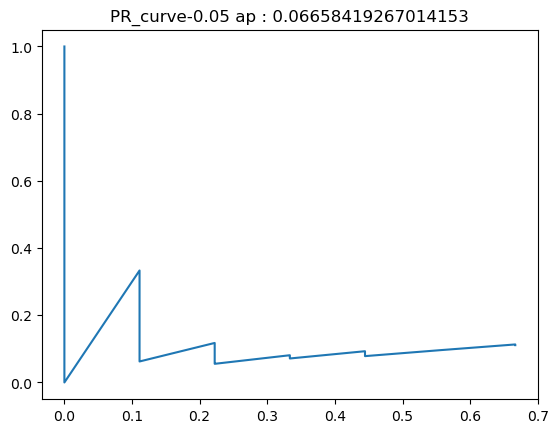

all_iou 0.7009002659469843
mIOU 0.0778778073274427


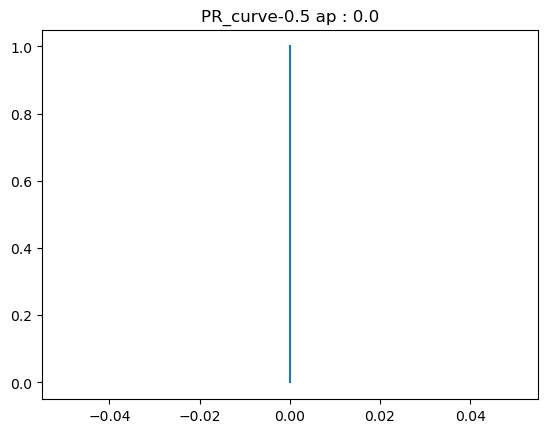

all_iou 0.7009002659469843
mIOU 0.0778778073274427


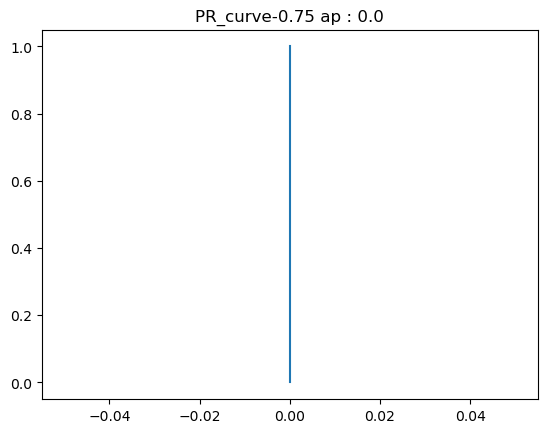

ep 9:  33%|███▎      | 1/3 [00:01<00:02,  1.46s/it]


KeyboardInterrupt: 

In [11]:
#BATCH_SIZE=6
#TRAIN_NAME = "hor-big-826-20-n256-1"
#TRAIN_NAME = "n20_big20-r3"

#train_dataset = CustomDataset( "./output/train_visiable_horizon_big_20.json"   )  
#eval_dataset = CustomDataset( "./output/test_visiable_horizon_big_10.json"   ) 

train_dataset = CustomDataset( f"../../anno/train_visiable_20_no_cross.json" , debug_doTrans= False  )  
eval_dataset = CustomDataset( f"../../anno/test_visiable_10_no_cross.json"  ,debug_doTrans=False ) 

train_dataloader = DataLoader(train_dataset, BATCH_SIZE , shuffle=True, drop_last =True)
eval_dataloader = DataLoader(eval_dataset, BATCH_SIZE , shuffle=False, drop_last =True)

  
ep_count = 1 if LOADED_EPOCH is None else LOADED_EPOCH+1
#train_loop()

#while True:
for i in range(10):    
    
    # ======= Train EPOCH =======
    net.train()
    train_loop(train_dataloader)    
    try:
        # ======= Eval EPOCH =======    
        if(ep_count % EVAL_GAP ==0):
            print("=========== EVAL =========")
            net.eval()
            with torch.no_grad():        
                auc = eval_loop(eval_dataloader)
                
                if(auc > save_auc) :
                    path = './output/'+ TRAIN_NAME  +'.pth'
                    save_model(net , path , ep_count , auc)
                    save_auc = auc
                if(ep_count % 5 == 0):
                    path = './output/'+ '1017_wAug_all_bk.pth'
                    save_model(net , path , ep_count , auc)
                '''
                '''
    except Exception as error:
        print ("Error! : " , error)        
        import datetime            
        current_time = datetime.datetime.now()
        current_time_str = current_time.strftime("%Y-%m-%d %H:%M:%S")

        log = {
            'timestamp': current_time_str ,
            'error': error.__dict__,            
        }
        print(log)            
        json_object = json.dumps(log, indent=4)                        
        with open(f"./output/error_log-{TRAIN_NAME}.json", "w") as outfile:
            outfile.write(json_object)

    ep_count+=1

#save_model(net,f'./output/{TRAIN_NAME}-final.pth' , ep_count , save_auc )
'''
'''

In [ ]:
#save_model(net,f'./output/{TRAIN_NAME}-with_aug_ep166.pth' , 166 , 0.6612 )


In [ ]:
net.eval()
with torch.no_grad():  
    eval_loop(eval_dataloader)

In [ ]:
#Save model
#save_path = './output/horizonn256u20d20.pth'
#save_model(net,save_path)

In [ ]:
# load model
#state_dict = torch.load(save_path, map_location='cpu')
#net.load_state_dict(state_dict['state_dict'])


In [ ]:
# Debug
'''
target_imgs = [
"/0310/panos/floor_01_partial_room_11_pano_23.jpg",
"1357/panos/floor_01_partial_room_08_pano_31.jpg",
"0636/panos/floor_02_partial_room_03_pano_74.jpg",
"0548/panos/floor_01_partial_room_12_pano_25.jpg",
"1060/panos/floor_01_partial_room_03_pano_42.jpg",
"0530/panos/floor_01_partial_room_15_pano_11.jpg"
]
'''
import torch
import json
from horizon_model_direct import HorizonNet
'''
train_dataset = CustomDataset( f"./output/{TRAIN_DATASET_NAME}"   )  
train_dataloader = DataLoader(train_dataset, BATCH_SIZE , shuffle=True, drop_last =True)
tr_data = next(iter(train_dataloader))

#device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device= 'cpu'
net = HorizonNet('resnet50', True , MAX_PREDICTION_COUNT).to(device)   # For server (small memory)

'''
fake_imgs = torch.rand((6,3,512,1024))
f = open('./error_log-n90-c0.1-r10-0912-all-ep1.json') 
data = json.load(f)
for k, v in data.items():    
    data[k]=torch.tensor( data[k]).to(device) 
'''
print(data.keys())
out = net(fake_imgs)   #[b , max_count , 5 ]
#out = predict(data)   #[b , max_count , 5 ]
out = torch.transpose(out , 1 , 2) #[b , 5 , max_count ]
'''

#pack_gt = (data['u'] , data['v_top'] , data['v_btm'] , data['du'] , data['dv_top'] , data['dv_btm'] , data['u_grad'])    
print(torch.rand_like(data['u']) .shape)
print(data['v_top'].shape)
print(out.shape)
pack_gt = (data['u'] , data['v_top'] , data['v_btm'] , data['du'] , data['dv_top'] , data['dv_btm'] , torch.rand_like(data['u']) )    
pack_gt = torch.cat(pack_gt , 1)
b, _ = pack_gt.shape
#pack_gt = pack_gt.reshape((b , 7 , -1 ))
pack_gt = pack_gt.reshape((b ,  6 , -1 ))
'''
pack_gt = encode(pack_gt)
print(pack_gt)
'''

(matched_gt_u , matched_gt_vtop , matched_gt_vbtm , matched_gt_du ,matched_gt_dvtop ,matched_gt_dvbtm) ,\
(matched_prd_u , matched_prd_vtop ,matched_prd_vbtm , matched_prd_du ,matched_prd_dvtop , matched_prd_dvbtm,),gt_idxs  = match_gt(pack_gt , out )



'''
(matched_gt_u , matched_gt_vtop , matched_gt_vbtm , matched_gt_du ,matched_gt_dvtop ,matched_gt_dvbtm) ,\
(matched_prd_u , matched_prd_vtop ,matched_prd_vbtm , matched_prd_du ,matched_prd_dvtop , matched_prd_dvbtm,),gt_idxs  = match_gt(pack_gt , out )
'''


In [ ]:
'''
target_imgs = [
"0310/panos/floor_01_partial_room_11_pano_23.jpg",
"1357/panos/floor_01_partial_room_08_pano_31.jpg",
"0636/panos/floor_02_partial_room_03_pano_74.jpg",
"0548/panos/floor_01_partial_room_12_pano_25.jpg",
"1060/panos/floor_01_partial_room_03_pano_42.jpg",
"0530/panos/floor_01_partial_room_15_pano_11.jpg"
]
'''

target_imgs = [
    '0661/panos/floor_01_partial_room_01_pano_26.jpg',
    '0544/panos/floor_01_partial_room_21_pano_48.jpg',
    '1369/panos/floor_01_partial_room_04_pano_9.jpg',
    '0883/panos/floor_01_partial_room_09_pano_28.jpg',
    '0404/panos/floor_01_partial_room_13_pano_6.jpg',
    '0142/panos/floor_01_partial_room_05_pano_30.jpg',
    '0823/panos/floor_01_partial_room_05_pano_14.jpg',
    '0313/panos/floor_01_partial_room_13_pano_33.jpg',
    '0167/panos/floor_01_partial_room_17_pano_49.jpg',
    '0831/panos/floor_01_partial_room_08_pano_10.jpg',
    '1222/panos/floor_01_partial_room_04_pano_43.jpg',
    '0868/panos/floor_02_partial_room_07_pano_58.jpg',
    '0513/panos/floor_01_partial_room_09_pano_9.jpg',
    '0672/panos/floor_01_partial_room_04_pano_4.jpg',
    '0840/panos/floor_02_partial_room_09_pano_55.jpg',
    '0467/panos/floor_01_partial_room_04_pano_32.jpg',
    '0968/panos/floor_01_partial_room_03_pano_19.jpg', 
    '0350/panos/floor_02_partial_room_05_pano_70.jpg', 
    '0759/panos/floor_01_partial_room_03_pano_11.jpg', 
    '1345/panos/floor_01_partial_room_01_pano_8.jpg']
f= open("./output/train_visiable_horizon_unique_w0.01_all_fixedbug.json")
all_json = json.load(f)
target = [a for a in all_json if a['image'] in target_imgs]
print(target)

In [ ]:
print(len(target))
json_object = json.dumps(target, indent=4)                        
with open(f"./output/testerr.json", "w") as outfile:
    outfile.write(json_object)